Before anything else, you need to set up your environment properly. 
- in terminal, run `$ ./SETUP_ENV.sh`
- then in this jupyter notebook select the "sparc_20250225" conda environment as your python kernel (top right)

In [62]:
# Set constants

DEVICE = "cpu" # IF YOU HAVE NVIDIA GPU: DEVICE="cuda", otherwise: DEVICE="cpu"
FS_SPARC_CODE = 50

# dir_data = Path(f"{DATA_ROOT}/sample_audio/")
# dir_data = Path("/projectnb/busplab/lbullock/sparc_never-stole")
# DATA_ROOT = "/projectnb/busplab/lbullock/sparc_sample_audio" # data root should where 
DATA_ROOT = "../data"

# Setup

In [63]:
# see custom-setup-20250225-BUSCC.txt for env initialization

In [64]:
import sys
import os
import glob
from pathlib import Path

sys.path.append("../")
# sys.path.insert(0,"/content/Speech-Articulatory-Coding/")


In [65]:
%load_ext autoreload
%autoreload 2
import importlib
# import sparc
from sparc import load_model
import copy
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# gdtw relies on prcompiled binaries--we need to make sure it's pip-installed. In a terminal
# conda activate <your-sparc-python-env>
# cd path/to/Speech-Articulatory-Coding/gdtw
# python setup.py build_ext --inplace
# pip install -e .

#from gdtw import gdtw
# gdtw.gdtw.
# import inspect
# inspect.getsource(gdtw) 

# if everything is set up correctly, the following should print "importing Latane gdtw" 
#importlib.reload(gdtw)
# vars(gdtw)  # used to inspect the 


In [67]:
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
from matplotlib.patches import ConnectionPatch
import scipy as sp
from scipy.interpolate import interp1d

import librosa
import textgrid



In [68]:
# suppress warnings 
import warnings
warnings.filterwarnings("ignore")

In [69]:
coder = load_model("en", device=DEVICE, use_penn=True)


load_model v3
load_model v3
Using PENN for pitch tracking.


In [70]:
coder.inverter.linear_model

Linear(in_features=1024, out_features=12, bias=True)

# Helper functions

In [71]:
hprc_channels = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
mngu_channels = [
    'T3_x', 'T3_y',   # TD → T3
    'T2_x', 'T2_y',   # TB → T2
    'T1_x', 'T1_y',   # TT → T1
    'JAW_x','JAW_y',  # LI → JAW
    'UL_x', 'UL_y',   # UL → UL
    'LL_x', 'LL_y'    # LL → LL
]
hprc2mngu = {
    'LIX': 'JAW_x',
    'LIY': 'JAW_y',
    'ULX': 'UL_x',
    'ULY': 'UL_y',
    'LLX': 'LL_x',
    'LLY': 'LL_y',
    'TTX': 'T1_x',
    'TTY': 'T1_y',
    'TBX': 'T2_x',
    'TBY': 'T2_y',
    'TDX': 'T3_x',
    'TDY': 'T3_y',
}
mngu2hprc = {v: k for k, v in hprc2mngu.items()}
idxs_hprc2mngu = [hprc_channels.index(mngu2hprc[c]) for c in mngu_channels]
idxs_mngu2hprc = [mngu_channels.index(hprc2mngu[c]) for c in hprc_channels]
# [hprc[i] for i in idxs_hprc2mngu]


# # hprc index to mngu index
# idxs_hprc2mngu = [
#     6, 7,   # LIX, LIY → JAW_x, JAW_y
#     8, 9,   # ULX, ULY → UL_x, UL_y
#     10, 11, # LLX, LLY → LL_x, LL_y
#     4, 5,   # TDX, TDY → T1_x, T1_y
#     2, 3,   # TBX, TBY → T2_x, T2_y
#     0, 1    #  TTX, TTY → T3_x, T3_y
# ]

# # mngu index to hprc index
# idxs_mngu2hprc = [
#     6, 7,   # T3_x, T3_y → TTX, TTY
#     8, 9,   # T2_x, T2_y → TBX, TBY
#     10,11,  # T1_x, T1_y → TDX, TDY
#     0, 1,   # JAW_x, JAW_y → LIX, LIY
#     2, 3,   # UL_x, UL_y → ULX, ULY
#     4, 5    # LL_x, LL_y → LLX, LLY
# ]

# # Check forward mapping
# # assert all([hprc[i] == mngu[j].replace("_", "").upper() for i, j in enumerate(idxs_hprc2mngu)])

# # Check reverse mapping
# # assert all([mngu[i] == hprc[j].lower().replace("x", "_x").replace("y", "_y") for i, j in enumerate(idxs_mngu2hprc)])
# [hprc[i] for i in idxs_hprc2mngu]

In [72]:
# Define EMA principle comonent transforms 
# ... matrices were previously computeted in matlab, we just read them in here

idxs_tongue = np.array([1, 2, 3, 4, 5, 6]) - 1
idxs_jaw = np.array([7, 8]) - 1
idxs_lips = np.array([9, 10, 11, 12]) - 1
idxs_UL = np.array([9, 10]) - 1
PC = pd.read_csv(f'../PC-12d.csv')
labels_PC = ['T_pc1', 'T_pc2', 'T_pc3', 'T_pc4', 'T_pc5', 'T_pc6', 'J_pc1', 'J_pc2', 'L_pc1', 'L_pc2', 'L_pc3', 'L_pc4']

def m2M(m, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  # m should be (12, ns)

  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL
  
  # # 1d version
  # mask_jawUL = np.ones_like(m)
  # mask_jawUL[np.concat([idxs_jaw, idxs_UL]),:] = 0

  # m_jawtile = np.tile(m[idxs_jaw,:], 6)

  # m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  # M = np.dot(np.linalg.inv(PC), m_jawrel)


  mask_jawUL = np.ones_like(m)
  # print(mask_jawUL)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL]),:] = 0

  m_jawtile = np.tile(m[idxs_jaw,:], [6, 1])

  m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  M = np.dot(np.linalg.inv(PC), m_jawrel)
  assert(M.shape[0]==12)

  return M


def M2m(M, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL

  mask_jawUL = np.ones_like(M)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL]), :] = 0

  m = np.dot(PC, M)
  
  m_jawtile = np.tile(m[idxs_jaw, :], [6, 1])
  m = m + np.multiply(mask_jawUL, m_jawtile)

  # assert(m.flatten().size==12)
  assert(m.shape[0]==12)

  return m


In [73]:
color_code = {"UL":mpl.colors.to_rgb("#EE3A5B"),
              "LL":mpl.colors.to_rgb("#FFD155"),
              "LI":mpl.colors.to_rgb("#959595"),
              "TT":mpl.colors.to_rgb("#43B962"),
              "TB":mpl.colors.to_rgb("#C44B9F"),
              "TD":mpl.colors.to_rgb("#0093B7"),
              "Loudness":mpl.colors.to_rgb("#FB754D"),
              "Pitch":mpl.colors.to_rgb("#FB754D"),}

HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

def plot_art(ax, art, labels=None, gap=5, skip_y=False,color=None, series_name="", alpha=1.0, lw=2, plot_velocity=False, pitch=None, loudness=None, periodicity=None):
    yticks=[]
    ytick_labels=[]
    # labels = reversed["UL","LL", "LI", "TT", "TB", "TD"]
    # chidxs = []
    # HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    # channel_label = HPRC_channel_label
    # for l in labels:
    #     chidxs.append(HPRC_channel_label.index(l+"X"))
    #     chidxs.append(HPRC_channel_label.index(l+"Y"))
    labels = labels.copy() # avoid mutating the object passed 
    if labels is None:
        labels = ['T3', 'T2', 'T1', 'JAW', 'UL', 'LL']
        labels = [l+d for l in labels for d in ["_x", "_y"]]
    if pitch is not None:
        labels.append('pitch')
        art = np.column_stack([art, pitch])
    if loudness is not None:
        labels.append('loudness')    
        art = np.column_stack([art, loudness])
    if periodicity is not None:
            labels.append('periodicity')    
            art = np.column_stack([art, periodicity])
    channel_label = list(labels) # make a copy of labels
    chidxs = np.arange(0, len(channel_label))


    time = np.arange(0, art.shape[0]) / 50
    # print(len(art))
    # print(time)
    for i, ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
        else:
            art_name = ch_label
            if color is None:
                color = color_code[art_name]
        x = art[:,ch_i]
        if i == 0 and series_name:
            ax.plot(time, x - gap * i, color=color, alpha=alpha, lw=lw, label=series_name)
        else:
            ax.plot(time, x - gap * i, color=color, alpha=alpha, lw=lw)

        # ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw, label=series_name)
        if plot_velocity:
            ax.plot(time, 2*np.concatenate(([0], np.diff(x))) - gap*i,color='r',alpha=alpha*0.5,lw=1)

        yticks.append(-gap*i)

    # i = i+1
    # # diffs = np.diff(art, axis=0)
    # # maxdiffs = np.max(diffs, axis = 1)
    # diffs = np.vstack([np.zeros((1, 12)), np.abs(np.diff(art, axis=0))])
    # maxdiffs = np.max(diffs, axis = 1)
    # ax.plot(time, 2*maxdiffs-gap*i,color='r',alpha=alpha*0.5,lw=lw)
    # yticks.append(-gap*i)
    # ytick_labels.append('~max velocity')

    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    # xticks= np.arange(0,len(art),50)
    # xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    # ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    # ax.set_xlim(0,len(art))
    # ax.legend()
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center')
    

    return yticks

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from matplotlib.animation import FFMpegWriter
ffmpeg_path = "/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/bin/ffmpeg"
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path



def animate_ema(df_ema, filepath_out, sensor_neutral, colors=None, trail_length=5, interval=50):
    """
    Create an animation of EMA articulators with fading comet trails, synchronized by timestamp.

    Parameters:
    df_ema (DataFrame): DataFrame containing columns ['series', 'time', 'T3_x', 'T3_y', ..., 'LL_x', 'LL_y'].
    filepath_out (str): Path to save the animation (e.g., 'animation.mp4').
    sensor_neutral (list): List of neutral (x,y) positions for sensors.
    colors (dict): Dictionary mapping 'series' values to colors (e.g., {'original':'black', 'perturbed':'red'}).
    trail_length (int): Length of the comet trail.
    interval (int): Interval between frames in milliseconds.
    """

    if colors is None:
        colors = {'original': 'black', 'perturbed': 'red'}

    sensors = ['T3', 'T2', 'T1', 'JAW', 'UL', 'LL']

    # Sort by time and group by 'series'
    df_ema = df_ema.sort_values(by='time')
    groups = df_ema.groupby('series')

    # Get unique sorted time points
    time_points = df_ema['time'].unique()

    fig, ax = plt.subplots(figsize=(6, 6))

    # Setting up plot limits
    padding = 1
    x_cols = [f'{s}_x' for s in sensors]
    y_cols = [f'{s}_y' for s in sensors]

    x_all = df_ema[x_cols].values
    y_all = df_ema[y_cols].values

    ax.set_xlim([-4, 8])
    ax.set_ylim([-6, 4])
    # ax.set_xlim(np.min(x_all) - padding, np.max(x_all) + padding)
    # ax.set_ylim(np.min(y_all) - padding, np.max(y_all) + padding)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('EMA Sensor Motion with Fading Comet Trails')
    ax.grid(True)
    ax.set_aspect('equal')

    scatters_dict = {}
    for series, group in groups:
        color = colors.get(series, 'gray')
        scatters = [ax.scatter([], [], color=color, s=50, alpha=1-(i/trail_length)) for i in range(trail_length)]
        scatters_dict[series] = scatters

    time_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, fontsize=12,
                        verticalalignment='top', horizontalalignment='right')

    def init():
        for scatters in scatters_dict.values():
            for scatter in scatters:
                scatter.set_offsets(np.empty((0, 2)))
        time_text.set_text('')
        return sum(scatters_dict.values(), []) + [time_text]

    def update(frame):
        current_time = time_points[frame]
        artists = []

        for series, group in groups:
            scatters = scatters_dict[series]

            current_group = group[group['time'] <= current_time]

            for trail_idx in range(trail_length):
                idx = -(trail_length - trail_idx)
                if abs(idx) <= len(current_group):
                    pos = current_group.iloc[idx]
                    sensor_positions = np.array([
                        [pos[f'{sensor}_x'], pos[f'{sensor}_y']] for sensor in sensors
                    ]) + sensor_neutral
                    scatters[trail_idx].set_offsets(sensor_positions)
                else:
                    scatters[trail_idx].set_offsets(np.empty((0, 2)))

                artists.append(scatters[trail_idx])

        time_text.set_text(f't={current_time:.2f}')
        artists.append(time_text)

        return artists

    ani = FuncAnimation(fig, update, frames=len(time_points), init_func=init,
                        blit=True, interval=interval)

    # Save animation (mp4 recommended)
    ani.save(filepath_out, writer='ffmpeg')
    plt.close(fig)


# Example usage (assuming df_ema and sensor_neutral are prepared as specified):
# sensor_neutral = np.array([[5.4407711, -0.27898258], [3.9024611, 0.090298139], [2.2748213, -0.49493390],
#                            [0.82840538, -2.8019209], [-1.0039096, -0.083905414], [-0.67326981, -2.5571942]])
# animate_ema(df_ema, 'ema_animation.mp4', sensor_neutral, {'original': 'black', 'perturbed': 'red'})

# SPARC helper functions

In [75]:
def sparc_analyse_wav(filename, target=None):
    # filename is the name of a wav file. in this function, we want to analyse the file and return sparc ema traces, MFCCs, and a spectrogram

    # target is an object that has already had target = sparc_analyse_wav(target_filename). 
    # if target is not None, we will attempt to warp the file to 
    # f = '/projectnb/busplab/lbullock/sparc_sample_audio/pAHk_aligned.wav'
    # f = Path('/projectnb/busplab/lbullock/sparc_sample_audio/pAHk_aligned.wav')

    # (filepath.parent / (filepath.stem + "_resynth" + filepath.suffix))
    # f = folder / "never-stole_she.wav"

    f = Path(filename)


    c = {}
    print(coder)
    # c["code_orig"] = copy.deepcopy(codes[0])
    c["code_orig"] = coder.encode(f)
    # resynthesize
    wav = coder.decode(**c["code_orig"])
    sf.write((f.parent / (f.stem + "_resynth" + f.suffix)), wav, coder.sr)

    c["fname"] = f.stem
    c["loudness"] = np.squeeze(c["code_orig"]['loudness'])
    c["ema"] = np.squeeze(c["code_orig"]['ema']) 
    c["pitch"] = np.squeeze(c["code_orig"]['pitch']) 
    c["periodicity"] = np.squeeze(c["code_orig"]['periodicity']) 

    c["time"] = np.arange(1, c["ema"].shape[0]+1) / FS_SPARC_CODE  

    # # Trim to equal length if needed (e.g., remove last sample)
    # if loudness is not None and loudness.shape[0] == ema.shape[0] + 1:
    #     loudness = loudness[:-1]
    # Assume: ema (T1, D), pitch (T2,), loudness (T3,)
    T = max(c["ema"].shape[0],
        c["pitch"].shape[0] if c["pitch"] is not None else 0,
        c["loudness"].shape[0] if c["loudness"] is not None else 0)
    if c["ema"].shape[0] < T:
        pad_width = ((0, T - c["ema"].shape[0]), (0, 0))
        c["ema"] = np.pad(c["ema"], pad_width, mode='edge')
    for feat in ["pitch", 'loudness', 'periodicity', 'time']:     
        if c[feat] is not None and c[feat].shape[0] < T:
            c[feat] = np.pad(c[feat], (0, T - c[feat].shape[0]), mode='edge')
    # if c["loudness"] is not None and c["loudness"].shape[0] < T:
    #     c["loudness"] = np.pad(c["loudness"], (0, T - c["loudness"].shape[0]), mode='constant')
    # if c["periodicity"] is not None and c["periodicity"].shape[0] < T:
    #     c["periodicity"] = np.pad(c["periodicity"], (0, T - c["periodicity"].shape[0]), mode='constant')

    # [print(k, c[k].shape) for k in c.keys() if k in ['ema', 'acoustic_wvlm', 'pitch', 'periodicity', 'loudness', 'time']]
    
    c["ema_pc"] = m2M(c["ema"].T, PC).T # convert from raw EMA sensors to EMA-principle components space



    # ------ 
    # Load audio and compute MFCCs
    c["wav"], c["wav_fs"] = librosa.load(f, sr=None)
    dur  = c["wav"].shape[0] / c["wav_fs"] 


    c["mfcc"] = librosa.feature.mfcc(y=c["wav"], sr=c["wav_fs"], n_mfcc=13)
    c["mfcc_time"] = (np.arange(0, c["mfcc"].shape[1]) / c["mfcc"].shape[1] * dur).squeeze()
    c["mfcc_delta"]= librosa.feature.delta(c["mfcc"].T)

    c["specgram"] = librosa.feature.melspectrogram(y=c["wav"], sr=c["wav_fs"], n_mels=128, fmax=8000)
    c["specgram_time"] = (np.arange(0, c["specgram"].shape[1]) / c["specgram"].shape[1] * dur).squeeze()

    c["mfcc"] = c["mfcc"].T
    c["specgram"] = c["specgram"].T

    # warp to target
    if target: 
        params = {
        "lambda_cum": 0.05, 
        "lambda_inst": 0.05,
        "Loss": "cosine"
        }

        # print('input shapes: ', c["mfcc_delta"].T.shape, target["mfcc_delta"].T.shape)
        [phi, mfcc2_warped, cost, g] = gdtw.warp(c["mfcc_delta"], target["mfcc_delta"], params=params)

        t = np.linspace(0, 1, len(target["specgram_time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values

        # Step 3: Interpolate follower spectrogram at warped times using linear interpolation
        S2_interp_func = interp1d(c["specgram_time"], c["specgram"], axis=0, bounds_error=False, fill_value=0)
        S2_warped = S2_interp_func(tau_sec)  # shape: (n_mels, N)
        # print(S2_warped.shape)

        c["warped"] = {}
        c["warped"]["phi"] = phi
        c["warped"]["fname"] = c["fname"] + "_warpto-" + target["fname"]
        # keys = ['code_orig', 'loudness', 'ema', 'pitch', 'periodicity', 'time', 'wav', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time']

        t = np.linspace(0, 1, len(target["time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values
        c["warped"]["time"] = target["time"]
        for feat in ['ema', 'ema_pc', 'loudness', 'pitch', 'periodicity']: 
            interp_func = interp1d(c["time"], c[feat], axis=0, bounds_error=False, fill_value=np.mean(c[feat]))
            c["warped"][feat] = interp_func(tau_sec)  # shape: (n_mels, N)


        t = np.linspace(0, 1, len(target["mfcc_time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values
        c["warped"]["mfcc_time"] = target["mfcc_time"]
        for feat in ['mfcc', 'mfcc_delta']: 
            interp_func = interp1d(c["mfcc_time"], c[feat], axis=0, bounds_error=False, fill_value=0)
            c["warped"][feat] = interp_func(tau_sec)  # shape: (n_mels, N)

        t = np.linspace(0, 1, len(target["specgram_time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values
        c["warped"]["specgram_time"] = target["specgram_time"]
        for feat in ['specgram']: 
            interp_func = interp1d(c["specgram_time"], c[feat], axis=0, bounds_error=False, fill_value=0)
            c["warped"][feat] = interp_func(tau_sec)  # shape: (n_mels, N)


        # resynthesize with warped 
        rs = {} # resynth
        rs["ema"] = c["warped"]['ema'][np.newaxis, :, :]
        rs["loudness"] = c["warped"]['loudness'][np.newaxis, :, np.newaxis]
        rs["pitch"] = c["warped"]['pitch'][np.newaxis, :, np.newaxis]
        rs["periodicity"] = c["warped"]['periodicity'][np.newaxis, :, np.newaxis]
        rs["spk_emb"] = c["code_orig"]['spk_emb'].copy()
        wav = coder.decode(**rs)
        sf.write((f.parent / (f.stem + "_warpto-" + target['fname'] + "_resynth" + f.suffix)), wav, coder.sr)
    return c


In [ ]:
def ensure_2d(x):
    return x[:, np.newaxis] if x.ndim == 1 else x

def apply_perturbation(code, perturbations, fs=50, sigma=3, coder=None, PC=PC):
    """
    Apply smooth temporal perturbations to a SPARC speech code object and synthesize audio.

    Parameters:
    - code: dict, the base speech code
    - perturbations: list of dicts, each describing a perturbation:
        {
            "feature": str, e.g. "ema", "ema_pc", "pitch", "loudness", "periodicity"
            "dim": int, index of the dimension to perturb
            "time": float, center of the perturbation window (in seconds)
            "magnitude": float, optional (for additive or absolute perturbation)
            "mode": "add" | "set" | "interpolate"
            "target_code": optional dict, only for "interpolate"
            "window": float, optional window duration in seconds (default determined by sigma)
        }
    - fs: int, sampling frequency of the signals
    - sigma: float, standard deviation for Gaussian smoothing in samples
    - coder: coder object with .decode() method (optional, for resynthesis)

    Returns:
    - code with a new code["pert"] dictionary
    """
    from scipy.ndimage import gaussian_filter1d
    import numpy as np

    pert = {}
    T = code["ema"].shape[0]

    # Clone original features
    for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
        if key in code:
            pert[key] = np.copy(code[key])

    time = code["time"]
    perturb_descriptions = []

    for p in perturbations:
        feature = p["feature"]
        dim = p["dim"]
        t0 = p["time"]
        mode = p.get("mode", "add")
        window = p.get("window", None)
        target_code = p.get("target_code", None)
        magnitude = p.get("magnitude", None)

        if mode is not "dilate" and feature not in pert:
            raise ValueError(f"Feature '{feature}' not in code")

        idx = np.argmin(np.abs(time - t0))

        impulse = np.zeros(T)
        impulse[idx] = 1.0
        if window:
            sigma_local = window * fs / 6  # 99.7% of Gaussian within ±3σ
        else:
            sigma_local = sigma

        smooth_envelope = gaussian_filter1d(impulse, sigma=sigma_local)
        smooth_envelope = smooth_envelope / smooth_envelope.max()

        if mode == "add":
            if feature in ['ema', 'ema_pc']: 
                base = (pert[feature])[:, dim]
                pert[feature][:, dim] = base + magnitude * smooth_envelope
            else: 
                # base = (pert[feature])[:, dim]
                pert[feature] += magnitude * smooth_envelope
            description = f"{feature}{dim}@{t0:.1f}s_+{magnitude:.2f}"
        elif mode == "set":
            if feature in ['ema', 'ema_pc']: 
                base = (pert[feature])[:, dim]
                pert[feature][:, dim] = base * (1 - smooth_envelope) + magnitude * smooth_envelope                
            else: 
                pert[feature] = pert[feature] * (1 - smooth_envelope) + magnitude * smooth_envelope           
            
            description = f"{feature}{dim}@{t0:.1f}s_set{magnitude:.2f}"
        elif mode == "interpolate":
            
            if target_code is None:
                raise ValueError("interpolate mode requires 'target_code'")
            target_feat = target_code[feature][:, dim]
            base = pert[feature][:, dim]
            pert[feature][:, dim] = base * (1 - smooth_envelope) + target_feat * smooth_envelope
            description = f"{feature}{dim}@{t0:.1f}s_interp"
        elif mode == "dilate":

            dilation = magnitude  # >1 lengthen, <1 shorten

            tt = np.diff(time, prepend=0) + np.diff(time, prepend=0) * (1 * smooth_envelope)
            warped_time = np.cumsum(tt)
            
            
            # 2. Créer un nouvel axe temporel **régulier** dans l’espace déformé
            time_new_linear = np.arange(0, warped_time[-1], 1/FS_SPARC_CODE)
            time_new_linear -= time_new_linear[0] - time[0] 
            # 3. Interpoler les signaux (features) sur cette nouvelle grille régulière
            for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
                if key not in pert:
                    continue
                y = pert[key]
                
                # Interpolateur basé sur le temps warpé
                if y.ndim == 1:
                    interp = interp1d(warped_time, y, bounds_error=False, fill_value=np.mean(y))
                    pert[key] = interp(time_new_linear)
                else:
                    interp = interp1d(warped_time, y, axis=0, bounds_error=False, fill_value=np.mean(y))
                    pert[key] = interp(time_new_linear)

            # 4. Stocker la nouvelle timebase régulière
            pert['time'] = time_new_linear

            # 5. (optionnel) Description de la transformation
            description = f"{feature}@{t0:.1f}s_dilatex{dilation:.2f}"

        else:
            raise ValueError(f"Unknown mode: {mode}")

        perturb_descriptions.append(description)

        if feature=="ema" and PC is not None: 
            pert["ema_pc"] = m2M(pert["ema"].T, PC).T
        elif feature=="ema_pc" and PC is not None:
            pert["ema"] = M2m(pert["ema_pc"].T, PC).T


    # Construct filename
    pert["fname"] = code["fname"] + "_pert_" + "-".join(perturb_descriptions)

    # Optional: synthesize perturbed audio
    if coder is not None:
        resynth_input = {
            "ema": pert["ema"][np.newaxis, :, :],
            "loudness": pert["loudness"][np.newaxis, :, np.newaxis],
            "pitch": pert["pitch"][np.newaxis, :, np.newaxis],
            "periodicity": pert["periodicity"][np.newaxis, :, np.newaxis],
            "spk_emb": code["code_orig"]["spk_emb"].copy()
        }
        wav = coder.decode(**resynth_input)
        pert["wav"] = wav

    code["pert"] = pert
    return code


# Prosody modulation: Visualize differences in SPARC EMA trajectories 

In [77]:
dir_data = Path(f"{DATA_ROOT}/never-stole")

# "target" refers to the template audio file that defines neutral prosody
c = dir_data / "never-stole_I.wav"
c = sparc_analyse_wav(c)



In [78]:
# sparc_analyse_wav(f, target=target) will 1) sparc-decompose the wav file f and 2) compute a timewarping function for the wav file f such that it aligns with target
#f = dir_data / "never-stole_said.wav"
#c = sparc_analyse_wav(f, target=target)


[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1  1.12
 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38 1.4
 1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66 1.68
 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94 1.96
 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22 2.24
 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5  2.52
 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78 2.8
 2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98 3.   3.02 3.04 3.06 3.08
 3.1  3.12 3.14 3.16 3.18 3.2  3.22 3.24 3.26 3.28 3.3  3.32 3.34 3.36
 3.38 3.4  3.42 3.44 3.46 3.48 3.5  3.52 3.54 3.56 3.58 3.6  3.62 3.64
 3.66 3.68 3.7  3.72 3.74 3.76 3.78 3.8  3.82 3.84 3.86 3.88 3.9  3.92
 3.94 3.

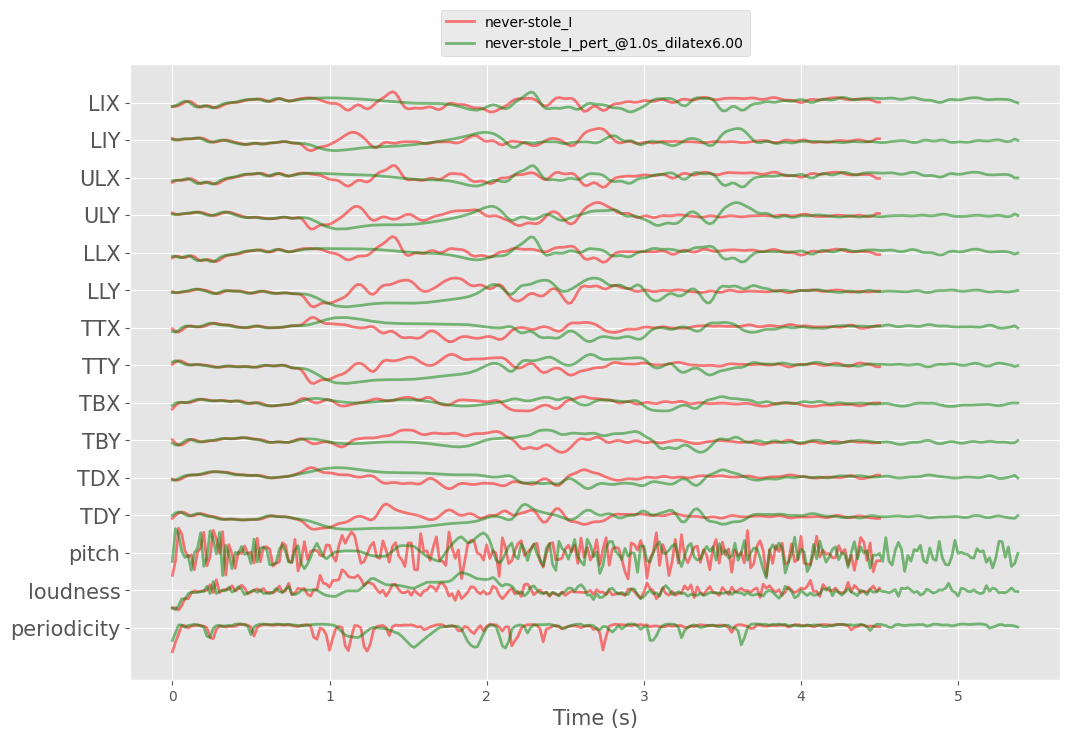

In [107]:

perturbations = [
# {"feature": "ema_pc", "dim": 6, "time": 1.3, "window": 1,  "magnitude": 2, "mode": "add"},
# {"feature": "pitch", "dim": 0, "time": 1, "window": 1,  "magnitude": 10,  "mode": "add"}, 
# {"feature": "pitch", "dim": 0, "time": 2, "window": 2,  "magnitude": 50,  "mode": "add"}, 
#{"feature": "pitch", "dim": 0, "time": 1, "window": 0.5,  "magnitude": 30,  "mode": "add"},
#{"feature": "loudness", "dim": 0, "time": 1, "window": 0.5,  "magnitude": 1,  "mode": "add"}, 
{"feature": "", "dim": 0, "time": 3, "window": 3,  "magnitude":6 ,  "mode": "dilate"}
# {"feature": "pitch", "dim": 0, "time": 1.6, "mode": "interpolate", "target_code": target_code}
]
# 0.8 for "never"
# 1.3 for "said"
c = apply_perturbation(c, perturbations, fs=50, sigma=1, coder=coder, PC=PC)
sf.write(dir_data / (c["pert"]["fname"] + ".wav"), c['pert']['wav'], coder.sr)
ipd.display(ipd.Audio(c['pert']['wav'], rate=coder.sr))
print(c["pert"]["time"])
print(c["time"])

c_plot = [c, c['pert']]
c_plot_colors = ['r', 'g', 'b']

# Plot and save
fig, ax = plt.subplots(figsize=(12, 8))
for i, code in enumerate(c_plot):
    # _, fname = os.path.split(files[i])
    fname = code['fname']
    plot_art(
        ax, code["ema"], # ema, ema_pc
        labels=hprc_channels, # hprc_channels, labels_PC
        color=c_plot_colors[i],
        series_name=fname, 
        gap=7, alpha=0.5, lw=2,
        pitch= code['pitch']-np.mean(code['pitch']), # sp.stats.zscore .... pitches[i], # pitches[i],
        loudness= sp.stats.zscore(code['loudness']), 
        periodicity= sp.stats.zscore(code['periodicity'])
    )

In [80]:
c_plot = [c, target, c['warped']]

# Step 4: Plot
fig = plt.figure(figsize=(12, 12))

# Top: warped follower spectrogram
ax_top = fig.add_subplot(311)
librosa.display.specshow(librosa.power_to_db(c_plot[0]["specgram"].T, ref=np.max),
                         sr=c_plot[0]["wav_fs"], x_axis='time', y_axis='mel', fmax=8000, 
                         ax=ax_top)
ax_top.set_title("Follower (Orig)")
# ax_top.label_outer()

# Middle: leader spectrogram
ax_mid = fig.add_subplot(312, sharex=ax_top)
librosa.display.specshow(librosa.power_to_db(c_plot[1]["specgram"].T, ref=np.max),
                         sr=c_plot[0]["wav_fs"], x_axis='time', y_axis='mel', fmax=8000, 
                         ax=ax_mid)
ax_mid.set_title("Leader (Target)")
# ax_mid.label_outer()

# Bottom: original follower spectrogram
ax_bot = fig.add_subplot(313, sharex=ax_top)
librosa.display.specshow(librosa.power_to_db(c_plot[2]["specgram"].T, ref=np.max),
                         sr=c_plot[0]["wav_fs"], x_axis='time', y_axis='mel', fmax=8000, 
                         ax=ax_bot)
ax_bot.set_title("Follower (Warped)")

NameError: name 'target' is not defined

['../data/audio-aligned-bob/BOB2-bought-dog_bob-aligned.wav', '../data/audio-aligned-bob/bob-BOUGHT2-dog_bob-aligned.wav', '../data/audio-aligned-bob/bob-bought-DOG2_bob-aligned.wav']
['../data/audio-aligned-bob/BOB2-bought-dog_bought-aligned.wav', '../data/audio-aligned-bob/bob-BOUGHT2-dog_bought-aligned.wav', '../data/audio-aligned-bob/bob-bought-DOG2_bought-aligned.wav']
['../data/audio-aligned-bob/BOB2-bought-dog_dog-aligned.wav', '../data/audio-aligned-bob/bob-BOUGHT2-dog_dog-aligned.wav', '../data/audio-aligned-bob/bob-bought-DOG2_dog-aligned.wav']


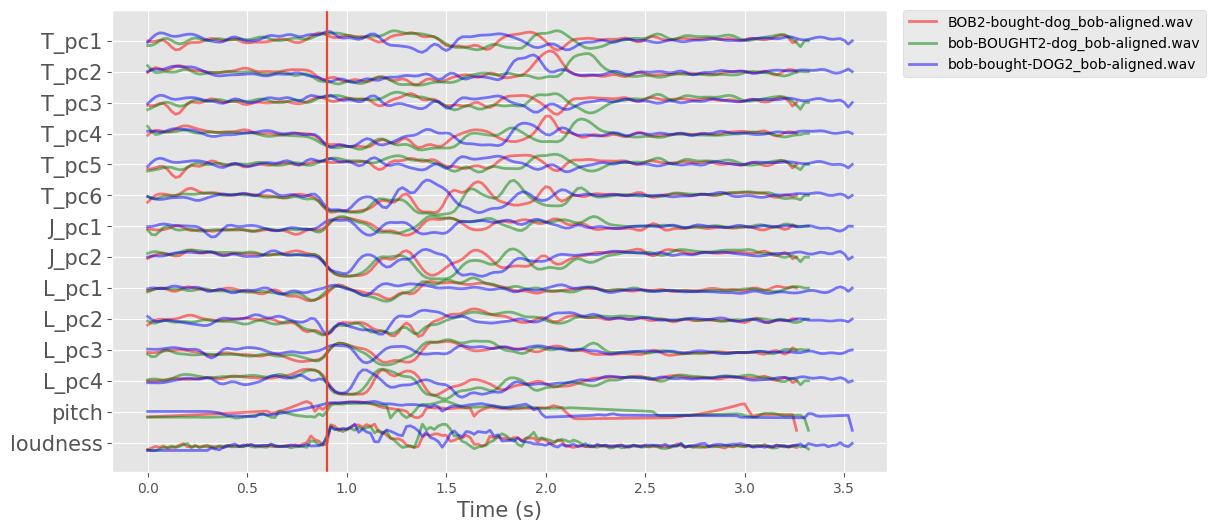

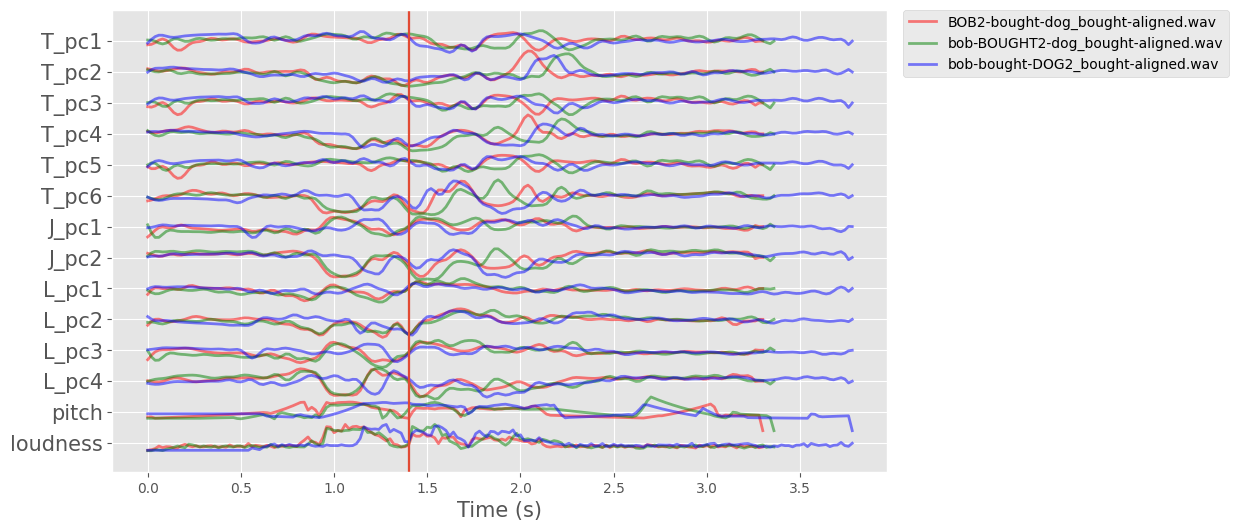

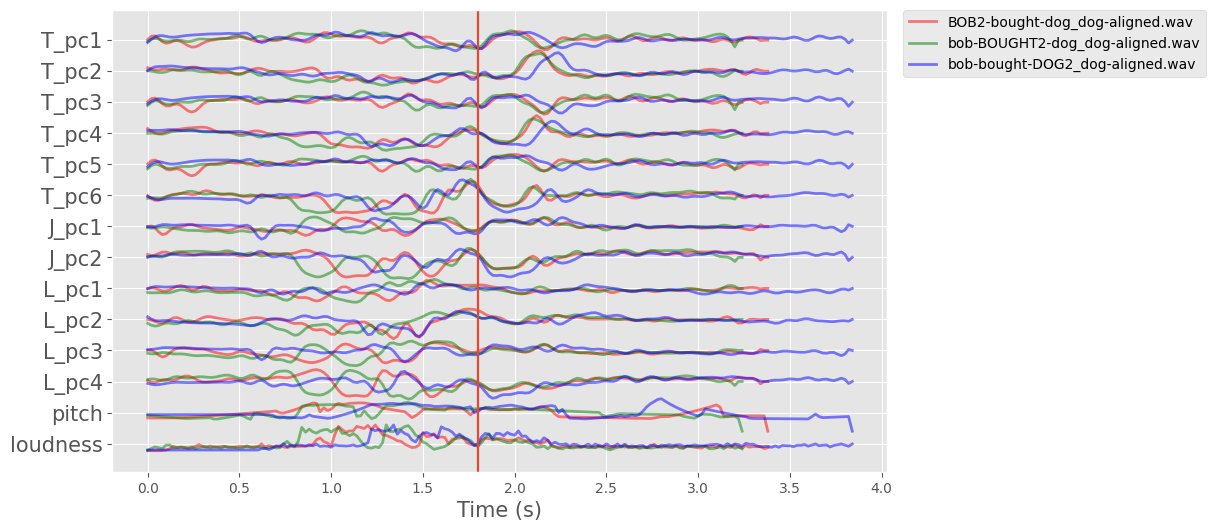

In [ ]:
# def plot_prosody_aligned_trajectories(coder, PC, labels_PC, output_dir, topdir):
"""
Process and plot articulator trajectories from a set of aligned .wav files
showing how prosody affects movement across alignments.

Parameters:
- coder: object with .encode() and .decode() methods
- PC: principal components (for projection)
- labels_PC: list of labels for PC dimensions
- output_dir: where to save the resulting plots
- topdir: root directory containing the sample_audio folder
"""
import glob
from pathlib import Path


folder = Path(DATA_ROOT) / "audio-aligned-bob"
alignment_types = ['bob', 'bought', 'dog']
alignment_times = [0.9, 1.4, 1.8]
emas_plot_colors = ['r', 'g', 'b']

for ialign, align in enumerate(alignment_types):
    files = sorted(glob.glob(str(folder / f"*_{align}-aligned.wav")))
    print(files)

    emas_plot = []
    pitches = []
    loudnesses = []

    def zscore_and_scale_to_max3(x):
        if x is None:
            return None
        x = (x - np.mean(x)) / np.std(x)  # z-score
        max_abs = np.max(np.abs(x))
        if max_abs > 0:
            x = x * (3.0 / max_abs)
        return x

    # Apply to pitch and loudness
    # pitch = zscore_and_scale_to_max3(pitch)
    # loudness = zscore_and_scale_to_max3(loudness)

    for f in files:
        # Use coder.encode to extract data
        code = coder.encode(f)
        ema = np.squeeze(code['ema'])  # (T, D)
        pitch = np.squeeze(code['pitch']) if 'pitch' in code else None
        loudness = np.squeeze(code['loudness']) if 'loudness' in code else None

        # # Trim to equal length if needed (e.g., remove last sample)
        # if loudness is not None and loudness.shape[0] == ema.shape[0] + 1:
        #     loudness = loudness[:-1]
        # Assume: ema (T1, D), pitch (T2,), loudness (T3,)
        T = max(ema.shape[0],
                pitch.shape[0] if pitch is not None else 0,
                loudness.shape[0] if loudness is not None else 0)
        if ema.shape[0] < T:
            pad_width = ((0, T - ema.shape[0]), (0, 0))
            ema = np.pad(ema, pad_width, mode='constant')
        if pitch is not None and pitch.shape[0] < T:
            pitch = np.pad(pitch, (0, T - pitch.shape[0]), mode='constant')
        if loudness is not None and loudness.shape[0] < T:
            loudness = np.pad(loudness, (0, T - loudness.shape[0]), mode='constant')

        pitch = zscore_and_scale_to_max3(pitch)
        loudness = zscore_and_scale_to_max3(loudness)


        # Project to PC space if needed
        # ema_pc = m2M(ema.T, PC).T  # shape: (T, num_PC) aroundtown['m'] = M2m(aroundtown['M'].T, PC).T
        ema_pc = ema

        emas_plot.append(ema_pc)
        pitches.append(pitch)
        loudnesses.append(loudness)

    # Plot and save
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, e in enumerate(emas_plot):
        _, fname = os.path.split(files[i])

        plot_art(
            ax, e,
            labels=labels_PC,
            color=emas_plot_colors[i],
            series_name=fname, 
            gap=5, alpha=0.5, lw=2,
            pitch= pitches[i], # pitches[i], # pitches[i],
            loudness=loudnesses[i]
        )
        ax.axvline(alignment_times[ialign])
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=10)

    # Save figure
    fig_path = Path(folder) / f"trajectories_ema_{align}.png"
    fig.savefig(fig_path)
    
    # plt.close(fig)

    # return f"Plots saved to {output_dir}"


# Utterance synthesis from word dictionary

In [ ]:

from scipy.interpolate import interp1d

FS_SPARC_CODE = 50  # Hz


def build_word_dictionary(wav_filename, textgrid_filename, margin_sec=0.5):
    wav_path = Path(wav_filename)
    tg = textgrid.TextGrid.fromFile(textgrid_filename)
    word_tier = [tier for tier in tg.tiers if tier.name.lower() == "word"]
    assert len(word_tier) == 1, "TextGrid must contain a 'word' tier"
    word_tier = word_tier[0]

    y, sr = sf.read(wav_filename)
    word_dict = {}

    for interval in word_tier.intervals:
        label = interval.mark.strip().lower()
        if label == "":
            continue

        start = max(0, interval.minTime - margin_sec)
        end = min(interval.maxTime + margin_sec, len(y) / sr)

        y_segment = y[int(start * sr): int(end * sr)]
        tmp_wav_path = wav_path.parent / f"tmp_{label}_{int(start*1000)}ms.wav"
        sf.write(tmp_wav_path, y_segment, sr)

        c = sparc_analyse_wav(tmp_wav_path)
        c['start_time'] = start
        c['end_time'] = end

        entry = {
            'sparc': {k: c[k] for k in ["ema", "pitch", "periodicity", "loudness", "time"]},
            'fs': sr,
            'start_time': start,
            'end_time': end,
            'fname': tmp_wav_path.name
        }

        word_dict.setdefault(label, []).append(entry)

    return word_dict

def synth_from_word_dictionary(
    utterance_string, word_dict, coder, spk_emb=None,
    smooth=True, crossfade=0.1, margin_sec=0.5,
    perturbations=None, apply_perturbation_fn=None
):
    """
    Concatenates SPARC codes for a given utterance using word_dict entries,
    trims margins, applies optional smoothing and stress-based perturbations,
    and returns waveform from coder.decode().

    Parameters:
    - utterance_string : str (e.g., "buy0 the0 cat1")
    - word_dict : dict
    - coder : model with .decode() method
    - spk_emb : optional speaker embedding
    - smooth : bool
    - crossfade : float, seconds of overlap smoothing
    - margin_sec : float, how much margin to trim from beginning/end
    - perturbations : list, one entry per stressed word (or None)
    - apply_perturbation_fn : callable, function to apply perturbation (required if perturbations is used)

    Returns:
    - dict with keys: code, wav, fname
    """
    import re
    from scipy.ndimage import zoom

    FS_SPARC_CODE = 50  # assumed global

    default_pert_template = [
        {"feature": "pitch", "dim": 0, "time": None, "window": None, "magnitude": 30, "mode": "add"},        
        {"feature": "loudness", "dim": 0, "time": None, "window": None, "magnitude": 1, "mode": "add"},
        {"feature": "", "dim": 0, "time": None, "window": None, "magnitude": 1.3, "mode": "dilate"},
    ]

    words = utterance_string.strip().split()
    word_specs = []
    for w in words:
        match = re.match(r"(\w+?)([01]?)$", w)
        if match:
            word = match.group(1).lower()
            stress = int(match.group(2)) if match.group(2) != '' else 0
            word_specs.append((word, stress))
        else:
            raise ValueError(f"Could not parse word/stress from token: '{w}'")

    code = {"ema": [], "pitch": [], "loudness": [], "periodicity": [], "time": []}
    time_offset = 0
    gap_frames = int(FS_SPARC_CODE * crossfade)
    margin_frames = int(FS_SPARC_CODE * margin_sec)
    stressed_durations = []

    for word, stress in word_specs:
        assert word in word_dict, f"Word '{word}' not in dictionary"
        entry = word_dict[word][0]

        segs = {}
        for key in ["ema", "pitch", "loudness", "periodicity", "time"]:
            seg = entry['sparc'][key]
            if seg.shape[0] > 2 * margin_frames:
                seg = seg[margin_frames:-margin_frames]
            segs[key] = seg

        t = segs['time']
        t = t - t[0] + time_offset
        segs['time'] = t
        word_duration = t[-1] - t[0]

        if stress == 1:
            stressed_durations.append((time_offset, word_duration))

        for key in ["ema", "pitch", "loudness", "periodicity"]:
            seg = segs[key]
            if smooth and len(code[key]) > 0:
                tail = code[key][-1][-gap_frames:]
                head = seg[:gap_frames]
                alpha = np.linspace(0, 1, gap_frames)[:, None]
                if tail.ndim == 1:
                    blended = (1 - alpha.squeeze()) * tail + alpha.squeeze() * head
                else:
                    blended = (1 - alpha) * tail + alpha * head
                code[key][-1] = np.vstack([code[key][-1][:-gap_frames], blended])
                seg = seg[gap_frames:]
            code[key].append(seg)

        code['time'].append(t)
        time_offset = t[-1] + 1 / FS_SPARC_CODE

    for k in code:
        code[k] = np.concatenate(code[k], axis=0)

    # Apply perturbations to stressed words
    if perturbations is not None and apply_perturbation_fn is not None:
        all_pert = []
        for i, (start_time, dur) in enumerate(stressed_durations):
            pert_list = perturbations[i] if perturbations[i] is not None else copy.deepcopy(default_pert_template)
            for p in pert_list:
                if p["time"] is None:
                    p["time"] = start_time + dur / 2
                if p["window"] is None:
                    p["window"] = dur
            # all_pert.extend(pert_list)
            code['fname'] = "_".join([w for w, _ in word_specs])
            code = apply_perturbation_fn(code, pert_list, fs=FS_SPARC_CODE, coder=None)
            code = code["pert"]
        final_code = code
    else:
        final_code = code

    resynth_input = {
        "ema": final_code["ema"][np.newaxis, :, :],
        "loudness": final_code["loudness"][np.newaxis, :, np.newaxis],
        "pitch": final_code["pitch"][np.newaxis, :, np.newaxis],
        "periodicity": final_code["periodicity"][np.newaxis, :, np.newaxis],
        "spk_emb": spk_emb if spk_emb is not None else np.zeros((1, 256))
    }
    wav = coder.decode(**resynth_input)

    return {"code": final_code, "wav": wav, "fname": "_".join([w for w, _ in word_specs])}


In [ ]:
# get speaker embedding
dir_data = Path(f"{DATA_ROOT}/")
f = dir_data / "dict_short.wav"
c = sparc_analyse_wav(f)
spk_emb = c['code_orig']['spk_emb']

In [ ]:
# folder = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/never-stole")
# dir_data = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/")
dir_data = Path(f"{DATA_ROOT}/")


marg_sec = 0.5
dict_word = build_word_dictionary(dir_data / "dict_short.wav", dir_data / "dict_short.TextGrid", margin_sec=marg_sec)
dict_word.keys()

dict_keys(['the', 'puppy', 'jumped', 'on', 'a', 'couch', 'buy', 'bobby', 'she', 'saw', 'cat'])

In [ ]:
# enter a text string that contains any of the above words from the dictionary in any order
# code stress with a "1" after the word of interest
s = "bobby jumped cat bobby the couch1 cat"
perts = [None]
r = synth_from_word_dictionary(s, dict_word, coder, spk_emb=spk_emb, smooth=False, crossfade=0.1, margin_sec=marg_sec, perturbations=perts, apply_perturbation_fn=apply_perturbation)
# sf.write((f.parent / (f.stem + "_warpto-" + target['fname'] + "_resynth" + f.suffix)), wav, coder.sr)


sf.write(dir_data / ('resynth-from-dict_' + s +'.wav'), r['wav'], coder.sr)
ipd.display(ipd.Audio(r['wav'], rate=coder.sr))

